# Stereo rig calibration estimation of extrinsics

In this recipe, you will learn how to calibrate a stereo pair, that is, an estimate relative rotation and translation between two cameras using the photos of a calibration pattern. This functionality is used when you're dealing with stereo cameras—you need to know the rig parameters to be able to reconstruct 3D information about the scene.

To calibrate a stereo pair using OpenCV, one must capture a few photos of a calibration pattern simultaneously from both cameras. In our case, we used a $9\times 6$ chessboard. We used the `cv2.findChessboardCorners` function to find corners of the board which we will use for rig parameters estimation. We also need calibration pattern points in its local coordinate system. Since we know the size of the pattern and its shape, we can explicitly construct the list of points—`pattern_points`. Note that the units used here will be used for the translation vector between two cameras.

The calibration itself is performed in the `cv2.stereoCalibrate` function. As input, it takes a list of image points and a list of pattern points. You can also specify initial guesses for calibration parameters, and specify which parameters you want to refine and which ones you want to keep unchanged. The function returns a calibration error in pixels, first camera parameters, first camera distortion coefficients, second camera parameters, second camera distortion coefficients, rotation and translation between cameras, and essential and fundamental matrices. 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
import os

%matplotlib auto
%pylab inline

def print_image(header,name,np_arr,
                start_First=0,end_First=1,start_Second=0,end_Second=2,start_3=0,end_3=5):
    print("------  {0:-<25}    Shape{1} {2}: {3:}".format(header, np_arr.shape, name, str(np_arr.dtype)) )
    shapes = np_arr.shape #print(shapes)
    if shapes[0] < end_First:
        end_First = shapes[0]
    if shapes[1] < end_Second:
        end_Second = shapes[1]
    if len(shapes)==3:
        if shapes[2] < end_3:
            end_3 = shapes[2]
    if len(shapes)==3:
        for i in range (start_First,end_First):
            print("[", sep='',end="")
            for j in range (start_Second,end_Second):
                print(np_arr[i,j,start_3:end_3], sep=' ', end=" ")
            print(']')
    if len(shapes)==2:
        for i in range (start_First,end_First):
            print("[", end=" ")
            #print(np_arr[i,start_Second:end_Second],sep=' ',end=" ") cutoff sting by<60
            for k in range (start_Second,end_Second):
                print(np_arr[i,k], end=" ")
            print(']')

def draw_grid(img, pxystep=None,major_color=None, pxstep=None,pystep=None):
    #print("{0} XY{1} color{2} X{3} Y{4}".format(img.shape, pxystep,major_color,pxstep,pystep))
    pXYstep = None; pXstep=None; pYstep=None; 
    major_Color=None; minor_Color=None; major_Alpha=None; minor_Alpha=None;
    if pxystep != None:
        pXYstep = pXstep = pYstep = pxystep;
    else:
        pXstep = pxstep if pxstep != None else 100
        pYstep = pystep if pystep != None else 100
    major_Color = major_color if major_color != None else (204, 204, 204) #'#CCCCCC'
    if pXstep != None:
        x = pXstep
        #Draw all lines on X
        while x < img.shape[1]:
            cv2.line(img, (x, 0), (x, img.shape[0]), color=major_Color, thickness=1)
            x += pXstep
    if pYstep != None:
        y = pYstep
        #Draw all lines on Y
        while y < img.shape[0]:
            cv2.line(img, (0, y), (img.shape[1], y), color=major_Color,thickness=1)
            y += pYstep
    return img

def plt_view_image(plt,list_images,figsize=(15,6), axis="off", cmap='gray'):
    plt.figure(figsize=figsize)
    n = len(list_images)  #; print(n)
    plot_number = 1
    for name, img in list_images:
        plt.subplot(1,n,plot_number)
        plt.axis(axis); plt.title(name)
        if cmap =='gray': plt.imshow(img,cmap='gray' )
        else: plt.imshow(img)
        plot_number = plot_number + 1
    plt.show()

def plt_view_grid(plt, axis ='off',
                  xy_sizeaxis =None,
                  xy_measuare =None,
                  x_min=-10, x_max=10, y_min=-10, y_max=10,
                  x_major_size=1, x_minor_size=0.2, y_major_size=1, y_minor_size=0.2,
                  major_color='#CCCCCC', major_alpha=0.5,
                  minor_color='#CCCCCC', minor_alpha=0.2
                 ):
    if xy_sizeaxis is None:  x_min=-10; x_max=10; y_min=-10; y_max=10;
    else: x_min, x_max, y_min, y_max = xy_sizeaxis

    if xy_measuare is None:  x_major_size=1; x_minor_size=0.2; y_major_size=1; y_minor_size=0.2;
    else: x_major_size, x_minor_size, y_major_size, y_minor_size = xy_measuare
        
    plt.xlim(x_min, x_max); plt.ylim(y_min, y_max);
    ax = plt.gca()
    x_major_ticks=np.arange(x_min,x_max,x_major_size); x_minor_ticks=np.arange(x_min,x_max,x_minor_size)
    y_major_ticks=np.arange(y_min,y_max,y_major_size); y_minor_ticks=np.arange(y_min,y_max,y_minor_size)
    ax.set_xticks(x_major_ticks)
    ax.xaxis.set_major_locator(MultipleLocator(x_major_size))
    ax.set_xticks(x_minor_ticks, minor=True)
    ax.set_yticks(y_major_ticks)
    ax.yaxis.set_major_locator(MultipleLocator(y_major_size))
    ax.set_yticks(y_minor_ticks, minor=True)
    plt.grid(which='major', color=major_color, alpha=major_alpha)
    plt.grid(which='minor', color=minor_color, alpha=minor_alpha)
    #plt.gca().invert_yaxis() plt.gca().invert_xaxis()
    
#help("modules")   
import sys             
print('\n'.join(sys.path))
print("current folder ==",os.getcwd())
#pip list

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
D:\HTML_DOC\Program\opencv\Packt\S09\env
C:\Program Files\Python38\python38.zip
C:\Program Files\Python38\DLLs
C:\Program Files\Python38\lib
C:\Program Files\Python38
d:\html_doc\program\opencv\packt\s09\env

d:\html_doc\program\opencv\packt\s09\env\lib\site-packages
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\pip-20.1-py3.8.egg
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\win32\lib
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\Pythonwin
d:\html_doc\program\opencv\packt\s09\env\lib\site-packages\IPython\extensions
C:\Users\polit\.ipython
current folder == D:\HTML_DOC\Program\opencv\Packt\S09\env


In [2]:
import glob

left_imgs  = list(sorted(glob.glob('data/stereo/case1/left*.png')))
right_imgs = list(sorted(glob.glob('data/stereo/case1/right*.png')))
assert len(left_imgs) == len(right_imgs)


######################################################
print(len(left_imgs))
for i in range(len(left_imgs)):
    print("{0:2}\t{1}\t{2}".format(i, left_imgs[i], right_imgs[i]))

left_img  = cv2.imread(left_imgs[0])
print_image('left_img','left_img',left_img,0,2,0,7)

13
 0	data/stereo/case1\left01.png	data/stereo/case1\right01.png
 1	data/stereo/case1\left02.png	data/stereo/case1\right02.png
 2	data/stereo/case1\left03.png	data/stereo/case1\right03.png
 3	data/stereo/case1\left04.png	data/stereo/case1\right04.png
 4	data/stereo/case1\left05.png	data/stereo/case1\right05.png
 5	data/stereo/case1\left06.png	data/stereo/case1\right06.png
 6	data/stereo/case1\left07.png	data/stereo/case1\right07.png
 7	data/stereo/case1\left08.png	data/stereo/case1\right08.png
 8	data/stereo/case1\left09.png	data/stereo/case1\right09.png
 9	data/stereo/case1\left11.png	data/stereo/case1\right11.png
10	data/stereo/case1\left12.png	data/stereo/case1\right12.png
11	data/stereo/case1\left13.png	data/stereo/case1\right13.png
12	data/stereo/case1\left14.png	data/stereo/case1\right14.png
------  left_img-----------------    Shape(480, 640, 3) left_img: uint8
[[0 0 0] [2 2 2] [4 4 4] [5 5 5] [6 6 6] [6 6 6] [5 5 5] ]
[[1 1 1] [2 2 2] [4 4 4] [6 6 6] [6 6 6] [6 6 6] [5 5 5] ]


No handles with labels found to put in legend.


------  left_pts-----------------    Shape(54, 1, 2) left_pts: float32
[[244.40834   94.123985] ]
[[274.40363  92.2132 ] ]
[[305.502    90.32179] ]
[[338.30807  88.80915] ]
[[371.71494  87.87463] ]
[[406.45355  86.72023] ]
[[441.62607  86.25035] ]


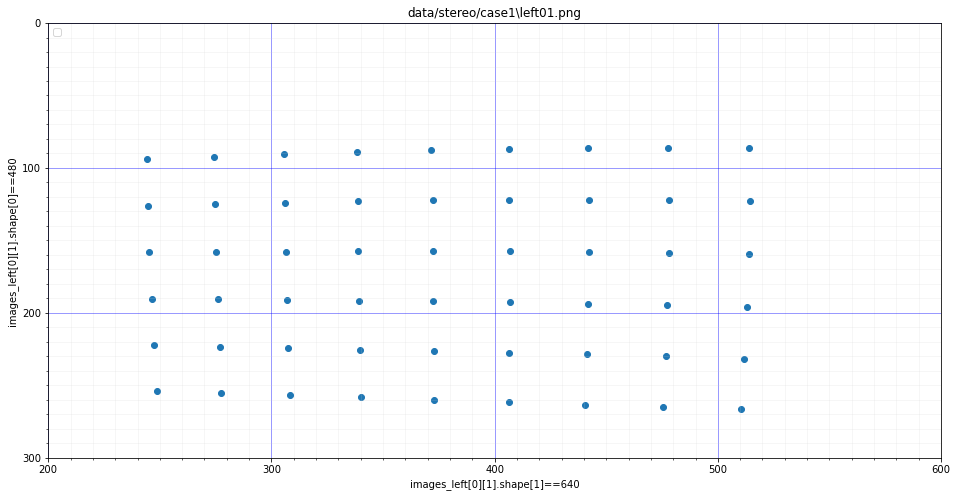

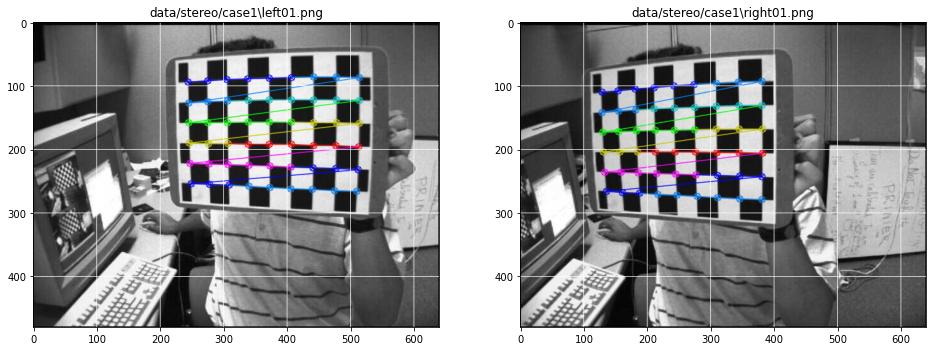

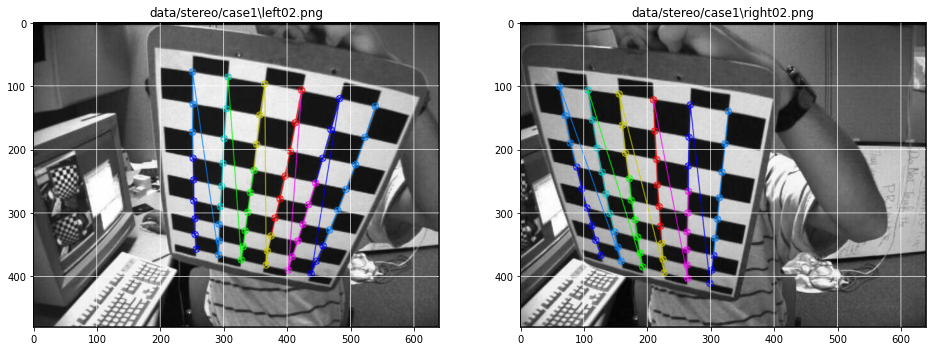

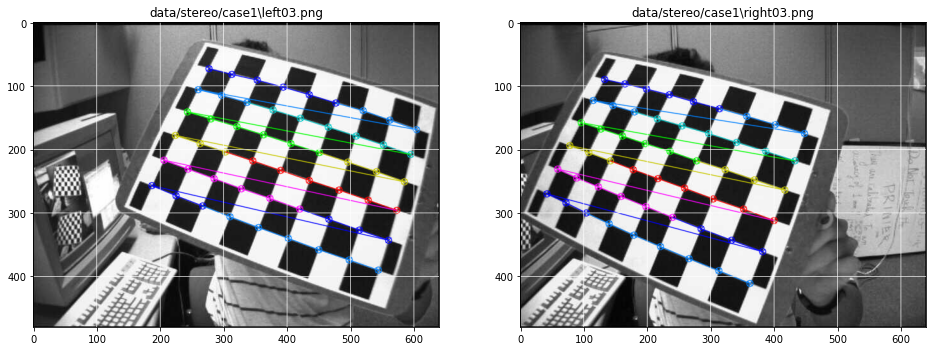

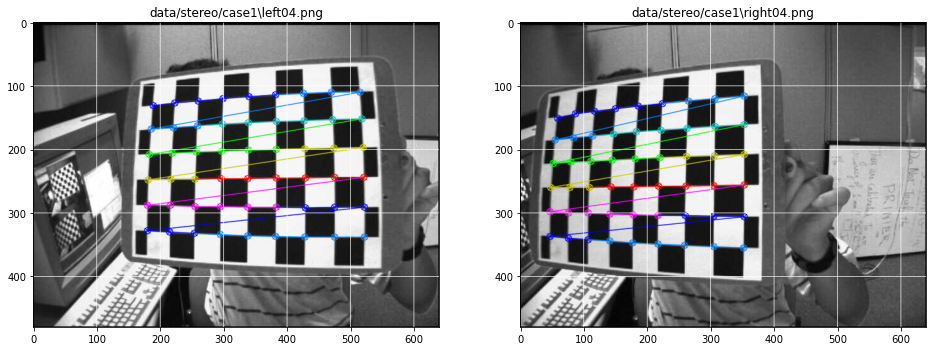

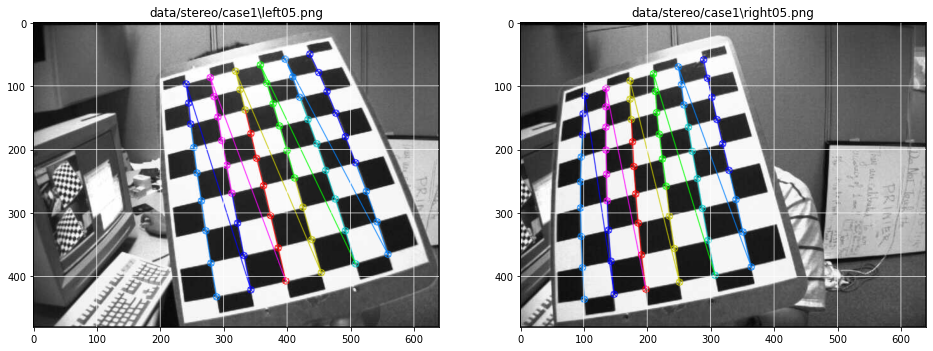

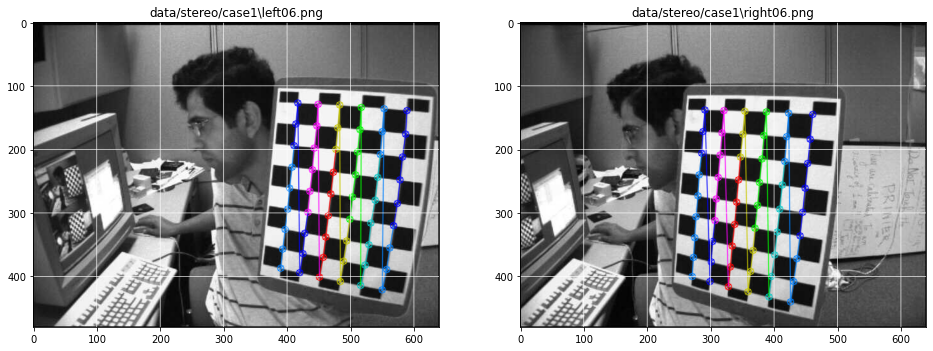

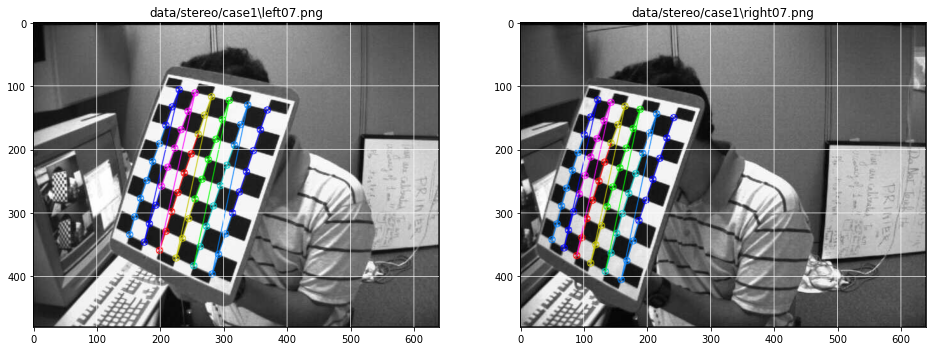

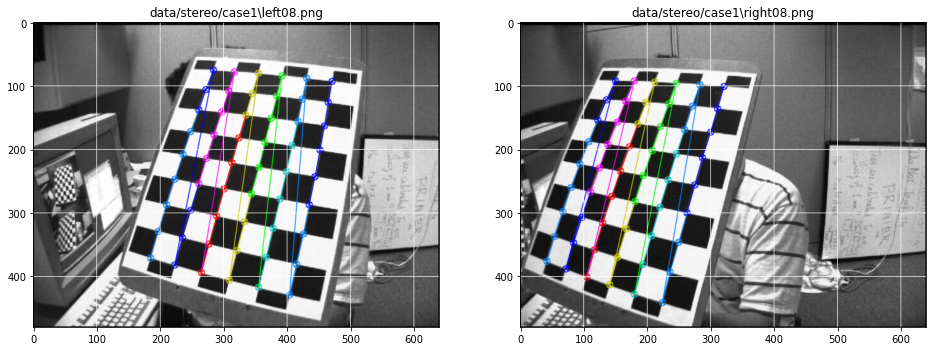

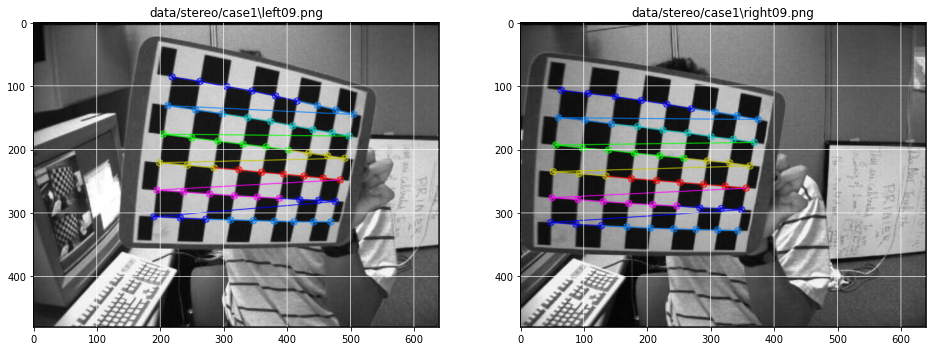

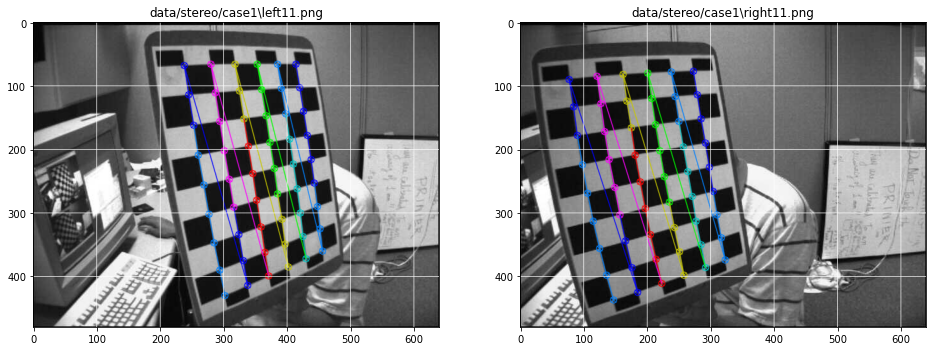

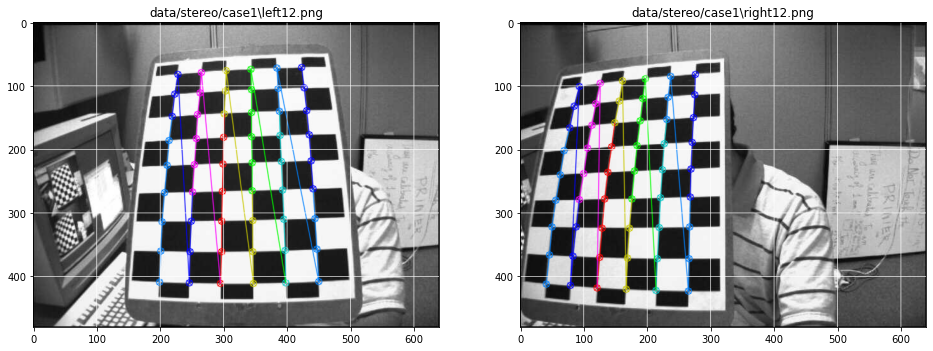

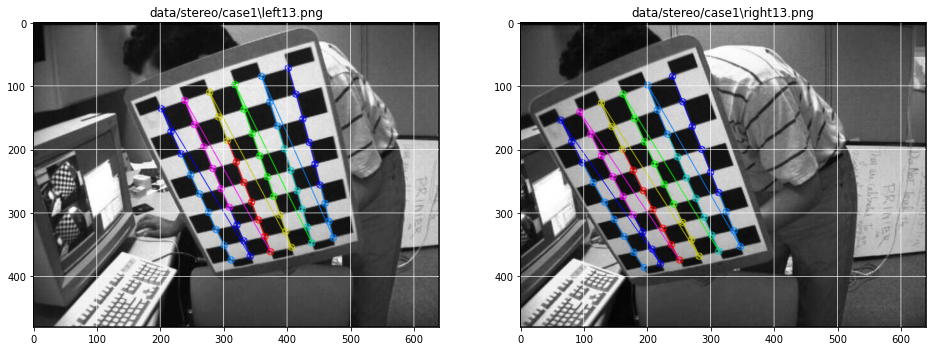

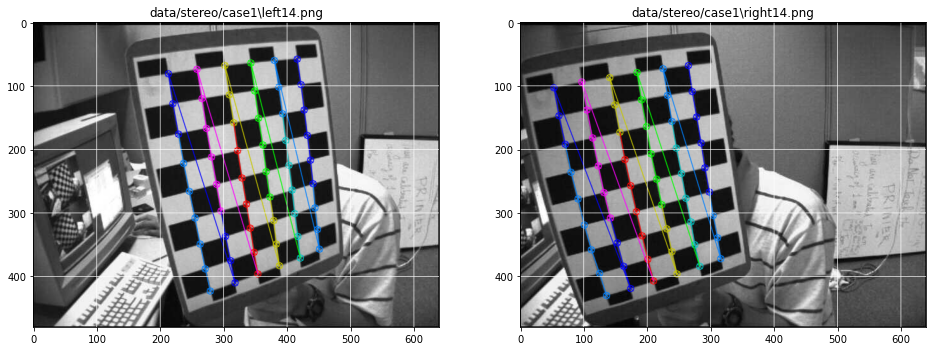

In [3]:
PATTERN_SIZE = (9, 6)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
left_pts, right_pts = [], []
img_size = None


images_left, images_right = [], []
for left_img_path, right_img_path in zip(left_imgs, right_imgs):
    left_img  = cv2.imread(left_img_path) #, cv2.IMREAD_GRAYSCALE)
    right_img = cv2.imread(right_img_path)#, cv2.IMREAD_GRAYSCALE)
    
    if img_size is None:
        img_size = (left_img.shape[1], left_img.shape[0])
    
    res_left,  corners_left  = cv2.findChessboardCorners(left_img,  PATTERN_SIZE)
    res_right, corners_right = cv2.findChessboardCorners(right_img, PATTERN_SIZE)
    

    #--------------------------------------------------------------------
    image_return_chess_left = cv2.drawChessboardCorners(np.copy(left_img), (6, 9), corners_left, res_left)
    image_return_chess_right= cv2.drawChessboardCorners(np.copy(right_img),(6, 9), corners_right,res_right)
    images_left.append([left_img_path,  image_return_chess_left])
    images_right.append([right_img_path,image_return_chess_right])
    #====================================================================
    

    left_img = cv2.cvtColor(left_img,  cv2.COLOR_BGR2GRAY)
    right_img= cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)
    corners_left  = cv2.cornerSubPix(left_img,  corners_left, (10, 10),(-1,-1),criteria)
    corners_right = cv2.cornerSubPix(right_img, corners_right,(10, 10),(-1,-1),criteria)
    
    left_pts.append(corners_left)
    right_pts.append(corners_right)
    


    

##########################################################    
print_image('left_pts','left_pts',left_pts[0],0,7,0,7)

plt.figure(figsize=(16,8))
plt_view_grid(plt, 'on',(200,600,0,300),(100,10,100,10),major_color='b')
plt.gca().invert_yaxis()

plt.scatter(left_pts[0][:,0,0], left_pts[0][:,0,1])
plt.xlabel('images_left[0][1].shape[1]=={}'.format(images_left[0][1].shape[1]));
plt.ylabel('images_left[0][1].shape[0]=={}'.format(images_left[0][1].shape[0]))
plt.title(images_left[0][0]);
plt.legend(loc='upper left')
plt.show()

for i in range(len(images_left)):
    plt_view_image(plt,[[images_left[i][0], draw_grid(np.copy(images_left[i][1]),100,(255,255,255))],
                        [images_right[i][0],draw_grid(np.copy(images_right[i][1]),100,(255,255,255))]],
               figsize=(16,8), axis='on', cmap='gray')

In [4]:
pattern_points = np.zeros((np.prod(PATTERN_SIZE), 3), np.float32)
pattern_points[:, :2] = np.indices(PATTERN_SIZE).T.reshape(-1, 2)
pattern_points = [pattern_points] * len(left_imgs)

In [5]:
err, Kl, Dl, Kr, Dr, R, T, E, F = cv2.stereoCalibrate(pattern_points, left_pts, right_pts, 
                                                      None, None, None, None, img_size, flags=0)

In [6]:
print('Left camera:')
print(Kl)
print('Left camera distortion:')
print(Dl)
print('Right camera:')
print(Kr)
print('Right camera distortion:')
print(Dr)
print('Rotation matrix:')
print(R)
print('Translation:')
print(T)

Left camera:
[[534.36681752   0.         341.45684657]
 [  0.         534.29616718 235.72519106]
 [  0.           0.           1.        ]]
Left camera distortion:
[[-2.79470900e-01  4.71876981e-02  1.39511507e-03 -1.64158448e-04
   7.01729203e-02]]
Right camera:
[[537.88729748   0.         327.29925115]
 [  0.         537.43063947 250.10021993]
 [  0.           0.           1.        ]]
Right camera distortion:
[[-0.28990693  0.12537789 -0.00040656  0.00053461 -0.03844589]]
Rotation matrix:
[[ 0.99998995  0.00355598  0.00273003]
 [-0.00354058  0.99997791 -0.00562461]
 [-0.00274997  0.00561489  0.99998046]]
Translation:
[[-3.33161159]
 [ 0.03706722]
 [-0.00420814]]


In [7]:
np.save('stereo.npy', {'Kl': Kl, 'Dl': Dl, 'Kr': Kr, 'Dr': Dr, 'R': R, 'T': T, 'E': E, 'F': F, 
                       'img_size': img_size, 'left_pts': left_pts, 'right_pts': right_pts})